![Some MNIST Digits](digits.png "")

## MNIST Data

[scikit-learn example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html)

In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

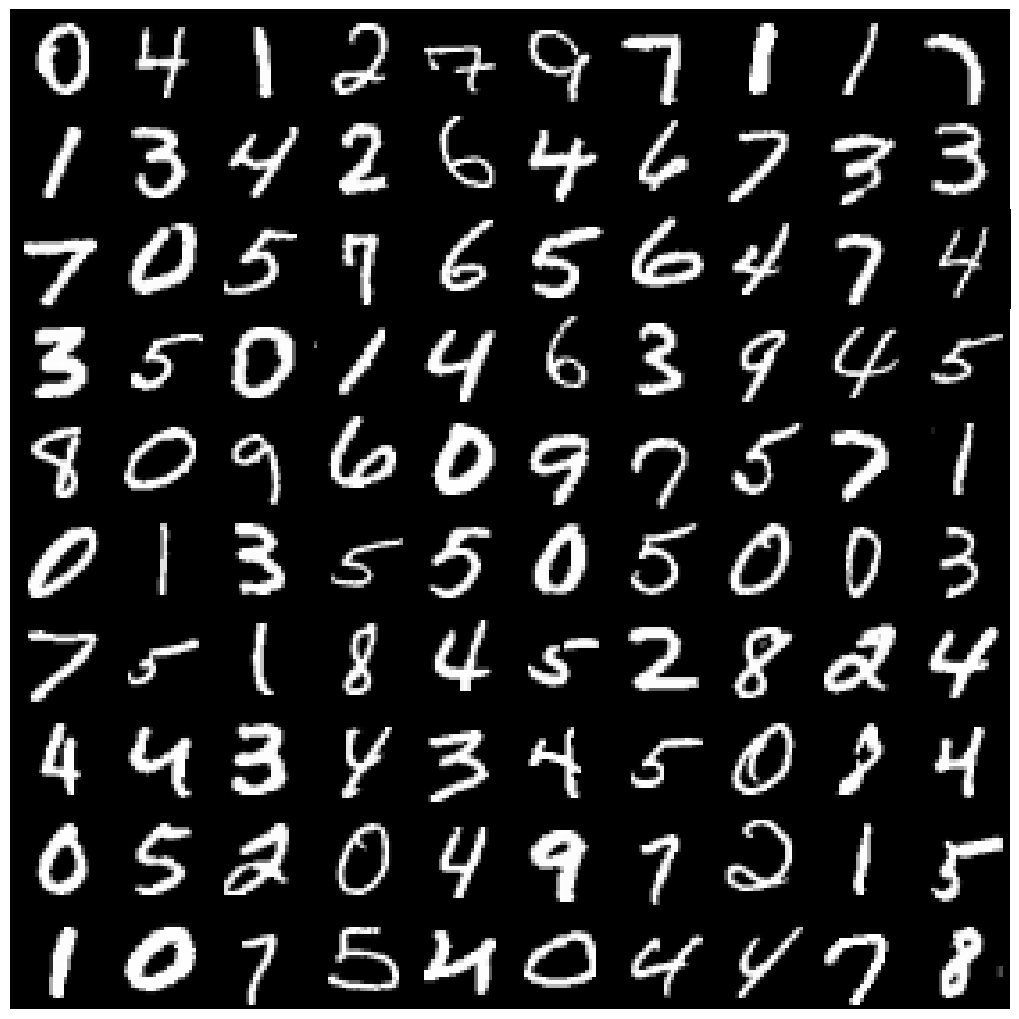

In [7]:
def plot_digits(X, n_rows, n_cols):
    X = X.reshape(-1, 28, 28)
    n_images = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

    # Flatten axs to iterate easily
    axs = axs.flatten()

    for i in range(n_images):
        axs[i].imshow(X[i], cmap="gray")
        axs[i].axis("off")  # turn off axes completely

    # Remove all spacing between plots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()

plot_digits(X, 10, 10) # post image
# plot_digits(X, 5, 5) # post thumbnail



In [218]:

# Turn up tolerance for faster convergence
C = 1e6 # 50.0 / train_samples
clf = LogisticRegression(C=C, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity: %.2f%%" % sparsity)
print("Test score: %.4f" % score)


Sparsity: 16.84%
Test score: 0.8787


In [252]:
def plot_class_weights(weights: np.ndarray, title: str = "Classification Weights"):
    num_classes = weights.shape[0]

    plt.figure(figsize=(10, 5))
    scale = np.abs(weights).max()

    for i in range(num_classes):
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(
            weights[i].reshape(28, 28),
            interpolation="nearest",
            # cmap=plt.cm.RdBu,
            cmap="viridis",
            vmin=-scale,
            vmax=scale,
        )
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel(f"Class {i}")

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])


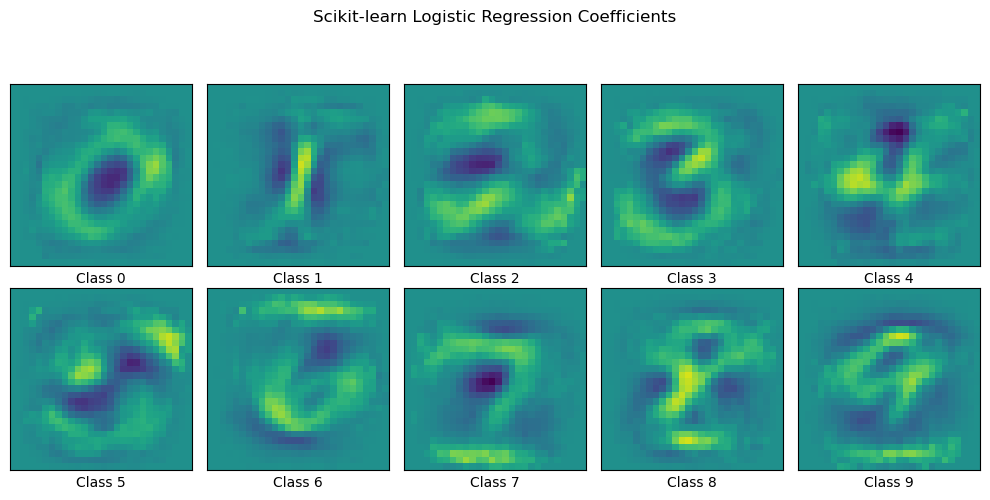

In [253]:
plot_class_weights(clf.coef_, title="Scikit-learn Logistic Regression Coefficients")

## PyTorch TensorDataset and DataLoader

In [247]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.int64), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(np.int64), dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
# batch_size = train_samples // 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## PyTorch Training Loop

In [250]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
input_size = 784  # 28x28
num_classes = 10  # Digits 0–9

# Hyperparameters
num_epochs = 5
learning_rate = 0.1

# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionModel(input_size, num_classes)

# Loss
criterion = nn.CrossEntropyLoss() # expects raw logits, not probabilities

# Optimizer with L2 penalty
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# l2_lambda = 0.5 / C  # same as scikit-learn's interpretation
# l2_lambda = 1e-4
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

# Training loop
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.view(-1, 28*28)  # Flatten
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch [1/5], Loss: 0.1806
Epoch [2/5], Loss: 0.7570
Epoch [3/5], Loss: 0.0647
Epoch [4/5], Loss: 1.0316
Epoch [5/5], Loss: 0.1636
Test Accuracy: 89.65%


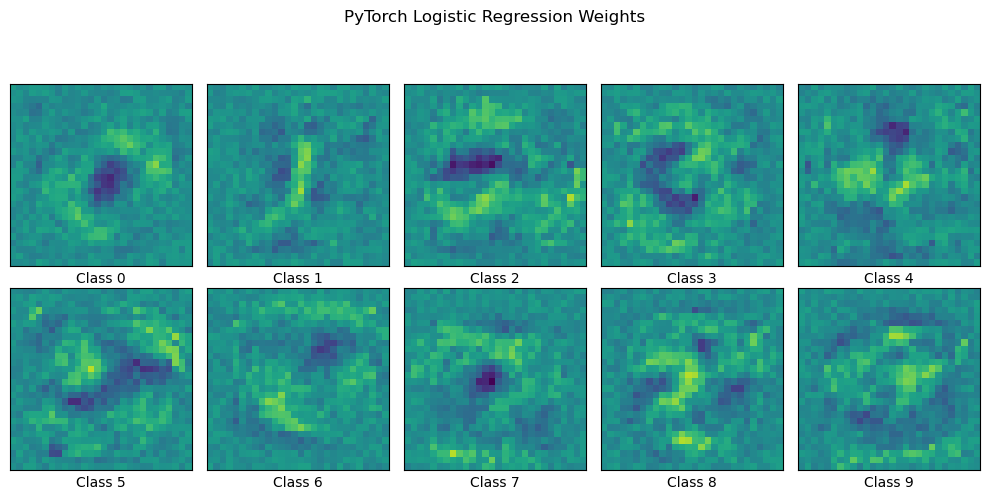

In [254]:
plot_class_weights(model.linear.weight.detach().numpy(), title="PyTorch Logistic Regression Weights")


## PyTorch Model Build and Training Loop- with SGD from scratch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
input_size = 784  # 28x28
num_classes = 10  # Digits 0–9

# Hyperparameters
num_epochs = 5
learning_rate = 0.1

def get_weights(*dims):
    return nn.Parameter(torch.randn(dims) / dims[0])

class LogRegFromScratch(nn.Module):
    def __init__(self, input_size, num_classes): 
        super().__init__()
        self.w = get_weights(input_size, num_classes)
        self.b = get_weights(num_classes)
    def forward(self, x):
        # x = x.view(x.size(0), -1) # flatten
        z = x @ self.w + self.b
        # x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return z

model = LogRegFromScratch(input_size, num_classes)
        

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # expects raw logits, not probabilities
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.view(-1, 28*28)  # Flatten
        outputs = model(images)
        loss = criterion(outputs, labels)

        # optimizer.zero_grad()
        if model.w.grad is not None:
            model.w.grad.data.zero_()
            model.b.grad.data.zero_()
        
        # we'll let pytorch compute the gradients
        loss.backward()
        
        # optimizer.step()
        model.w.data -= model.w.grad.data * learning_rate
        model.b.data -= model.b.grad.data * learning_rate
   

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch [1/5], Loss: 0.1180
Epoch [2/5], Loss: 0.1397
Epoch [3/5], Loss: 0.2134
Epoch [4/5], Loss: 0.0980
Epoch [5/5], Loss: 0.1619
Test Accuracy: 89.62%


## PyTorch Tensors

[Tensors](https://docs.pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

In [142]:
t1 = torch.tensor([[1, 2], [3, 4]])
t1[0, :]
t1[..., -1]
t2 = torch.tensor(range(20))
t2.shape
t2.view(-1, 2, 2)[0]
t3 = torch.tensor(range(27)).view(-1, 3, 3)
t3.shape

torch.Size([3, 3, 3])

## Layers

In [64]:
x_mini = torch.from_numpy(X_train[:3, ...]).float()
x_mini.shape

torch.Size([3, 28, 28])

In [67]:
# Flatten
x_flattened = nn.Flatten()((x_mini))
x_flattened.shape

torch.Size([3, 784])

In [68]:
# Linear
x_linear1 = nn.Linear(28*28, 15)(x_flattened)
x_linear1.shape

torch.Size([3, 15])

In [73]:
# ReLU
x_hidden1 = nn.ReLU()(x_linear1)
x_hidden1.shape

torch.Size([3, 15])

In [83]:
# Sequential
seq = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 15),
    nn.ReLU(),
    nn.Linear(15, 30),
    nn.ReLU(),
    nn.Linear(30, 10),
    nn.Softmax(dim=1)
)
seq(x_mini).shape

torch.Size([3, 10])

In [79]:
# Softmax
x_softmax = nn.Softmax(dim=1)(seq(x_mini))
x_softmax

tensor([[0.0936, 0.1094, 0.1268, 0.0971, 0.0794, 0.1210, 0.0921, 0.0818, 0.1055,
         0.0933],
        [0.0821, 0.0985, 0.1271, 0.0911, 0.0830, 0.1246, 0.0941, 0.0862, 0.1118,
         0.1015],
        [0.0882, 0.0997, 0.1235, 0.1006, 0.0828, 0.1206, 0.0933, 0.0879, 0.1029,
         0.1004]], grad_fn=<SoftmaxBackward0>)

In [84]:
for name, param in seq.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: 1.weight | Size: torch.Size([15, 784]) | Values : tensor([[-0.0238, -0.0017, -0.0260,  ...,  0.0321,  0.0211, -0.0249],
        [-0.0091,  0.0124, -0.0121,  ..., -0.0136, -0.0014,  0.0193]],
       grad_fn=<SliceBackward0>) 

Layer: 1.bias | Size: torch.Size([15]) | Values : tensor([0.0262, 0.0105], grad_fn=<SliceBackward0>) 

Layer: 3.weight | Size: torch.Size([30, 15]) | Values : tensor([[ 0.2526,  0.1591, -0.0362,  0.0020,  0.1605,  0.1606, -0.2301,  0.1060,
         -0.0991,  0.1354,  0.1294, -0.0413,  0.1145,  0.1495, -0.0890],
        [ 0.1291,  0.1532,  0.2153,  0.1283,  0.1212, -0.2326,  0.1690, -0.2046,
         -0.0258,  0.1576, -0.0288,  0.1905, -0.2454, -0.0010,  0.1243]],
       grad_fn=<SliceBackward0>) 

Layer: 3.bias | Size: torch.Size([30]) | Values : tensor([ 0.2565, -0.1671], grad_fn=<SliceBackward0>) 

Layer: 5.weight | Size: torch.Size([10, 30]) | Values : tensor([[ 0.1059,  0.0944, -0.1532, -0.0381, -0.0710,  0.0663, -0.1793,  0.0676,
          0.0654, -0.1

No parameters in the flatten, ReLU, or softmax layers. Only in the linear layers.

## NN with PyTorch

In [12]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)

## Autograd and Linear Regression

In [102]:
x_mini = torch.from_numpy(X_train[:3,...]).float()
x_flattened = nn.Flatten()(x_mini)
y_mini = torch.zeros(3, 10)
w = torch.randn(28*28, 10, requires_grad=True)
b = torch.randn(10, requires_grad=True)
z = x_flattened @ w + b
loss = nn.functional.binary_cross_entropy_with_logits(z, y_mini)
loss.backward()

In [106]:
b.grad

tensor([0.0333, 0.0939, 0.0999, 0.0333, 0.0878, 0.0014, 0.0333, 0.0333, 0.0666,
        0.0667])

## NN From Scratch

In [110]:
def get_weights(*dims):
    return nn.Parameter(torch.randn(dims) / dims[0])

class LogReg(nn.Module):
    def __init__(self): 
        super().__init__()
        self.l1_w = get_weights(28*28, 10)
        self.l1_b = get_weights(10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x.matmul(self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x

model = LogReg()
        

In [111]:
opt = torch.optim.SGD(model.parameters())